# PUBG Finish Placement Prediction

![](https://github.com/4ku/PUBG-prediction/raw/master/pictures/banner.png)

## 1. Feature and data explanation

At first, tell something about the game. **PlayerUnknown's Battlegrounds (PUBG)** -  an online multiplayer battle royale game.  Up to 100 players are dropped onto an island empty-handed and must explore, scavenge, loot and eliminate other players until only one is left standing, all while the play zone continues to shrink.  <br/>
Battle Royale-style video games have taken the world by storm. So PUBG becomes very popular. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.<br/>


<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/player-unknown-battlegrounds-freefall.jpg" width="1000" height="600"> 

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/maxresdefault.jpg" width="1000" height="600"> 

**The task**:  using player statistic during the match, predict final placement of this player, where 0 is last place and 1 is winner winner, chicken dinner. 
<br/><br/>
Dataset contains over 65,000 games' worth of anonymized player data, which you can download from [kaggle](https://www.kaggle.com/c/pubg-finish-placement-prediction/data) website. Each row of data is player stats at the end of the match.  <br/> 
The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group. <br/>
Statistics can be like - player kills,  his/her match, group and personal ID,  amount walked distance and etc...
<br/> **WinPlacePerc** - is a target feature on a scale from 1 (first place) to 0 (last place) - percentile winning placement.
 <br/>  <br/>
A solution of the task can be valuable for PUBG players, for understanding, what parameters are important, which tactic to choose. Also using [PUBG Developer API](https://developer.pubg.com/) we can collect our own data with more features. So it makes real to create a lot of different apps, which will help players. For example, app with personal assisstant, who will give a tips, what skill you should to train . 
 <br/>  <br/>
Let's look to the data

## 2-3 Primary data analysis and visual data analysis

In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sc
import gc
import warnings

In [47]:
plt.rcParams['figure.figsize'] = 15,8
sns.set(rc={'figure.figsize':(15,8)})
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
gc.enable()

In [48]:
train = pd.read_csv('../input/train_V2.csv')
test = pd.read_csv('../input/test_V2.csv')
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.00,0,0.00,0,0,244.80,1,1466,0.44
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.00,0,11.04,0,0,1434.00,5,0,0.64
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.00,0,0.00,0,0,161.80,2,0,0.78
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.00,0,0.00,0,0,202.70,3,0,0.17
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.00,0,0.00,0,0,49.75,2,0,0.19


### Data fields

* **DBNOs** - Number of enemy players knocked.
* **assists** - Number of enemy players this player damaged that were killed by teammates.
* **boosts** - Number of boost items used.
* **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
* **headshotKills** - Number of enemy players killed with headshots.
* **heals** - Number of healing items used.
* **Id** - Player’s Id
* **killPlace** - Ranking in match of number of enemy players killed.
* **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is * a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* **killStreaks** - Max number of enemy players killed in a short amount of time.
* **kills** - Number of enemy players killed.
* **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* **matchDuration** - Duration of match in seconds.
* **matchId** - ID to identify match. There are no matches that are in both the training and testing set.
* **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* **revives** - Number of times this player revived teammates.
* **rideDistance** - Total distance traveled in vehicles measured in meters.
* **roadKills** - Number of kills while in a vehicle.
* **swimDistance** - Total distance traveled by swimming measured in meters.
* **teamKills** - Number of times this player killed a teammate.
* **vehicleDestroys** - Number of vehicles destroyed.
* **walkDistance** - Total distance traveled on foot measured in meters.
* **weaponsAcquired** - Number of weapons picked up.
* **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* **groupId** - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* **numGroups** - Number of groups we have data for in the match.
* **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


We have 4.5 millions of player stats records! <br/>
<br/>
Now check dataset for missing values

In [50]:
display(train[train.isnull().any(1)])
display(test[test.isnull().any(1)])

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.00,0,0,0,1,0,0,0,0.00,9,solo-fpp,1,1,1574,0,0.00,0,0.00,0,0,0.00,0,0,nan


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints


There are only one row with nan value, so let's drop it

In [51]:
train.drop(2744604, inplace=True)

General info about aech column

In [52]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00,4446965.00
mean,0.23,1.11,130.72,0.66,0.23,1.37,47.60,505.01,0.92,0.54,23.00,1579.51,44.50,43.01,892.01,0.16,606.12,0.00,4.51,0.02,0.01,1154.22,3.66,606.46,0.47
std,0.59,1.72,170.78,1.15,0.60,2.68,27.46,627.50,1.56,0.71,50.97,258.74,23.83,23.29,736.65,0.47,1498.34,0.07,30.50,0.17,0.09,1183.50,2.46,739.70,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,133.00,2.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,24.00,0.00,0.00,0.00,0.00,1367.00,28.00,27.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,155.10,2.00,0.00,0.20
50%,0.00,0.00,84.24,0.00,0.00,0.00,47.00,0.00,0.00,0.00,0.00,1438.00,30.00,30.00,1443.00,0.00,0.00,0.00,0.00,0.00,0.00,685.60,3.00,0.00,0.46
75%,0.00,2.00,186.00,1.00,0.00,2.00,71.00,1172.00,1.00,1.00,21.32,1851.00,49.00,47.00,1500.00,0.00,0.19,0.00,0.00,0.00,0.00,1976.00,5.00,1495.00,0.74
max,22.00,33.00,6616.00,53.00,64.00,80.00,101.00,2170.00,72.00,20.00,1094.00,2237.00,100.00,100.00,5910.00,39.00,40710.00,18.00,3823.00,12.00,5.00,25780.00,236.00,2013.00,1.00


We can already guess, that the target feature has uniform distribution. It's because winPlacePerc is already scaled feature and after every match player can have only one place.

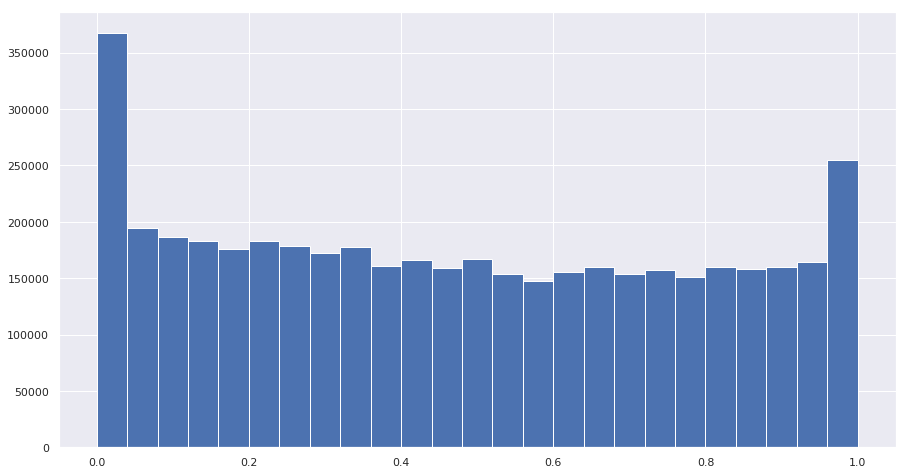

In [53]:
train['winPlacePerc'].hist(bins=25);

We can notice, that 0 and values are more than others.  It's because first and last place exists in every match) <br/>
WinPlacePerc has obviously uniform distribution, but let's check target feature for normality and skewness of distribution (becouse of task) 

In [54]:
print(sc.normaltest(train['winPlacePerc']))
print('Skew: ', sc.skew(train['winPlacePerc']))

NormaltestResult(statistic=6456876.444084833, pvalue=0.0)
Skew:  0.09882959417670069


Pvalue is zero, so this distribution is not normal <br/>
Skew is close to zero, so distribution is almostly symmetric

Now look at distrubution of features with upper limit (to get rid of outliers)  and without zero values (because of lots of zero values)
<br/>Also make boxplots to see correlation target feature from feature values

In [55]:
def featStat(featureName, constrain,plotType):
    feat = train[featureName][train[featureName]>0]
    data = train[[featureName,'winPlacePerc']].copy()
    q99 = int(data[featureName].quantile(0.99))
    plt.rcParams['figure.figsize'] = 15,5;   
    
    if constrain!=None:
        feat = feat[feat<constrain]
    if plotType == 'hist':
        plt.subplot(1,2,1)
        feat.hist(bins=50);
        plt.title(featureName);
        
        n = 20
        cut_range = np.linspace(0,q99,n)
        cut_range = np.append(cut_range, data[featureName].max())
        data[featureName] = pd.cut(data[featureName],
                                         cut_range,
                                         labels=["{:.0f}-{:.0f}".format(a_, b_) for a_, b_ in zip(cut_range[:n], cut_range[1:])],
                                         include_lowest=True
                                        )
        ax = plt.subplot(1,2,2)
        sns.boxplot(x="winPlacePerc", y=featureName, data=data, ax=ax, color="#2196F3")
        ax.set_xlabel('winPlacePerc', size=14, color="#263238")
        ax.set_ylabel(featureName, size=14, color="#263238")
        plt.gca().xaxis.grid(True)
        plt.tight_layout()
           
    if plotType == 'count':        
        plt.subplot(1,2,1)
        sns.countplot(feat, color="#2196F3");
        
        plt.subplot(1,2,2)
        data.loc[data[featureName] > q99, featureName] = q99+1
        x_order = data.groupby(featureName).mean().reset_index()[featureName]
        x_order.iloc[-1] = str(q99+1)+"+"
        data[featureName][data[featureName] == q99+1] = str(q99+1)+"+"
        
        ax = sns.boxplot(x=featureName, y='winPlacePerc', data=data, color="#2196F3", order = x_order);
        ax.set_xlabel(featureName, size=14, color="#263238")
        ax.set_ylabel('WinPlacePerc', size=14, color="#263238")
    plt.tight_layout()

**Kills and damage**

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Best%20win.gif" width="600" height="400"> 

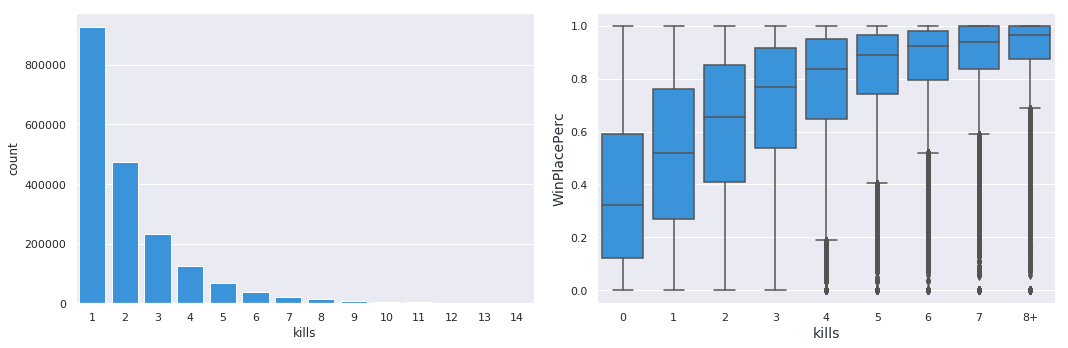

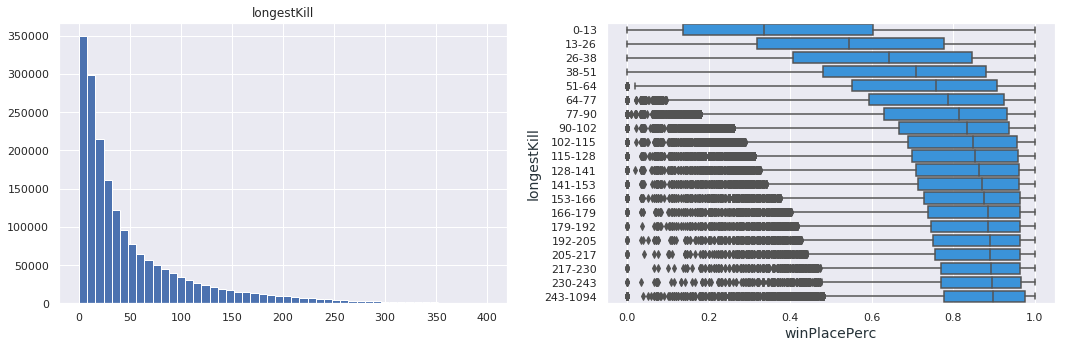

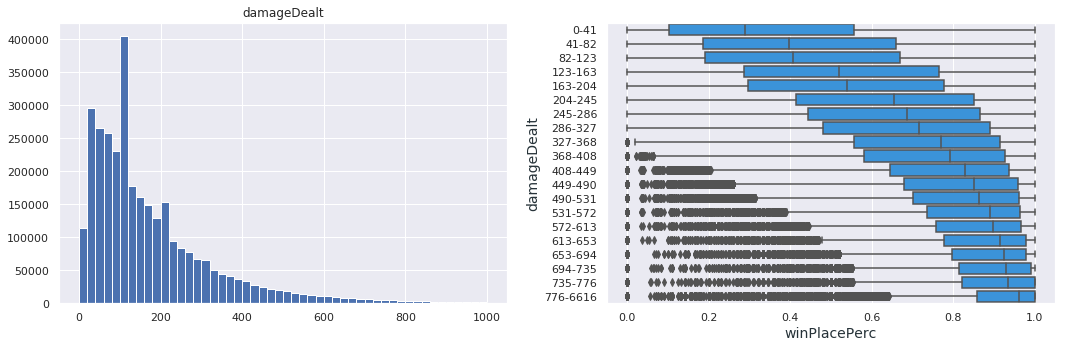

In [56]:
featStat('kills',15,'count');
plt.show();
featStat('longestKill',400,'hist');
plt.show();
featStat('damageDealt',1000,'hist');

**Heals and boosts**

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Boosters.png" width="800" height="600"> 

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Heals.gif" width="600" height="400"> 

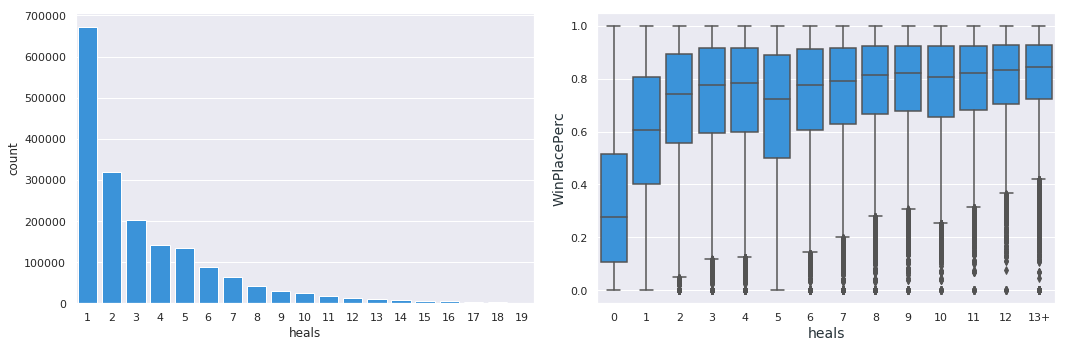

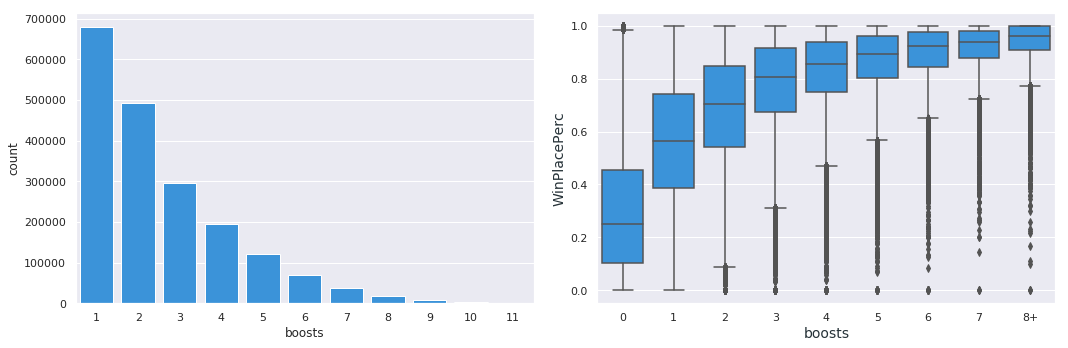

In [57]:
featStat('heals',20,'count')
plt.show()
featStat('boosts',12,'count')

**Distance**

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/pubg-bike.jpg" width="1200" height="800"> 

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Car%20kill.gif" width="600" height="400"> 

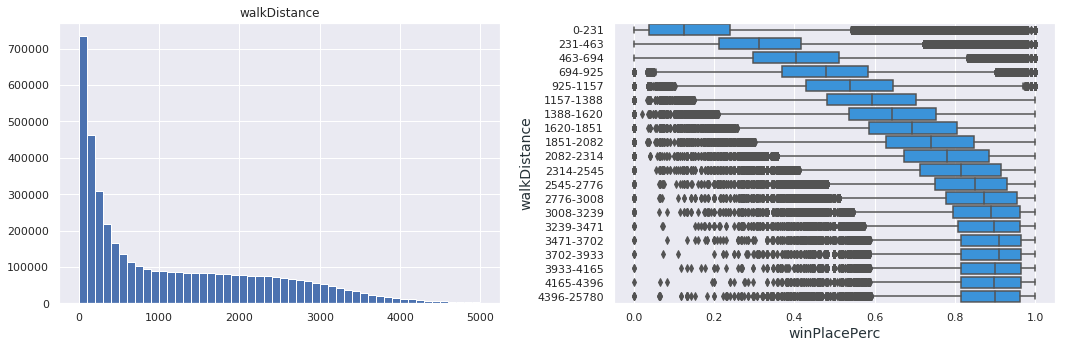

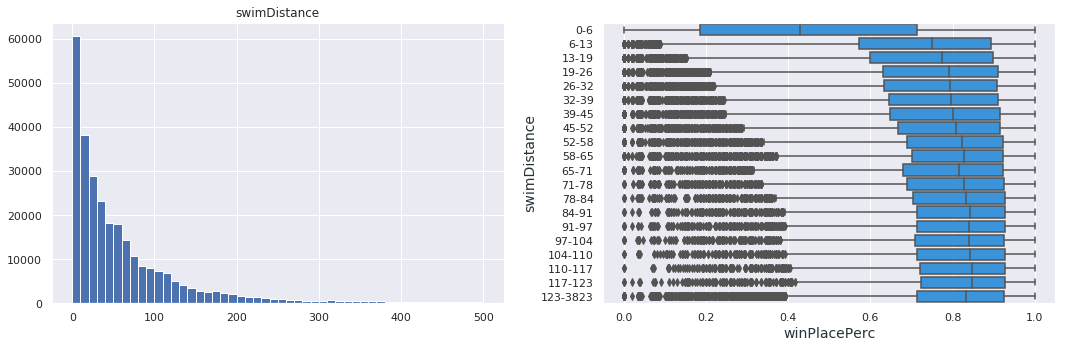

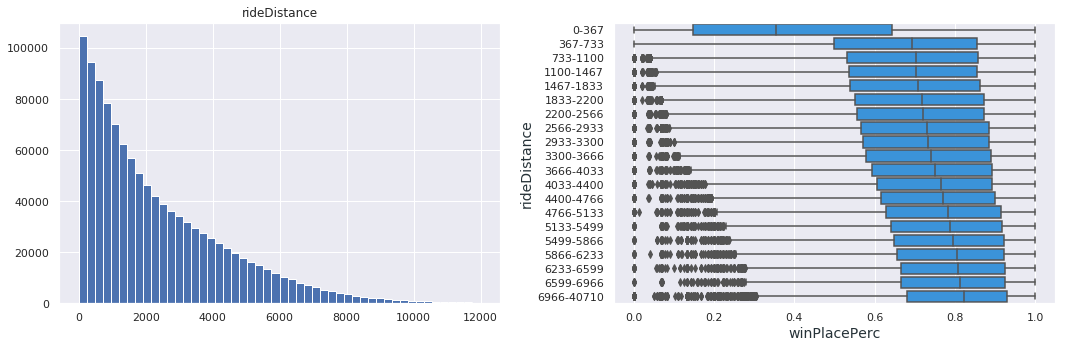

In [58]:
featStat('walkDistance',5000,'hist')
plt.show()
featStat('swimDistance',500,'hist')
plt.show()
featStat('rideDistance',12000,'hist')

**Some other features**

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Car%20destroy.gif" width="600" height="400"> 

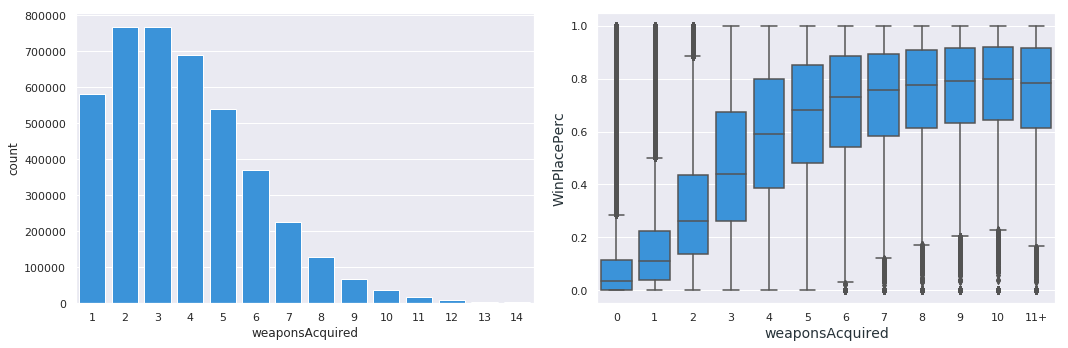

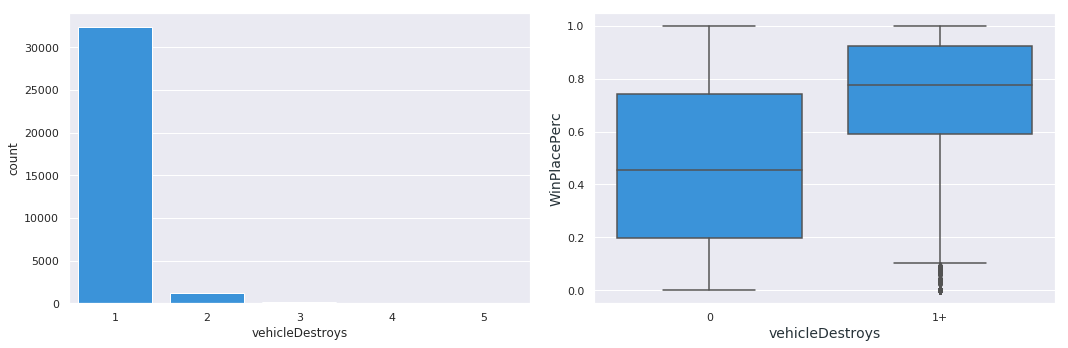

In [59]:
featStat('weaponsAcquired',15,'count')
plt.show()
featStat('vehicleDestroys',None,'count')

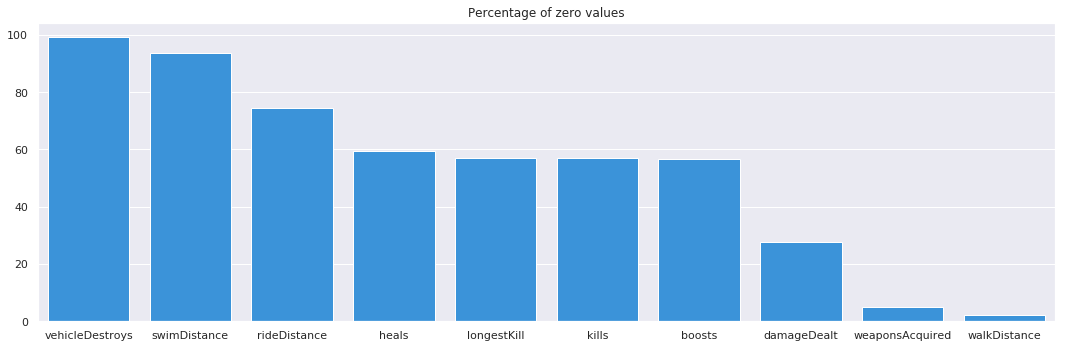

In [60]:
features = ['kills', 'longestKill', 'damageDealt', 'heals', 'boosts', 'walkDistance', 'swimDistance', 'rideDistance', 'weaponsAcquired', 'vehicleDestroys']
zeroPerc = ((train[features] == 0).sum(0) / len(train)*100).sort_values(ascending = False)
sns.barplot(x=zeroPerc.index , y=zeroPerc, color="#2196F3");
plt.title("Percentage of zero values")
plt.tight_layout()

As we can see, with increasing of value of this features, probability to win also increase. So features, described above, good correlate with target feature. <br/>
Plot remaining features

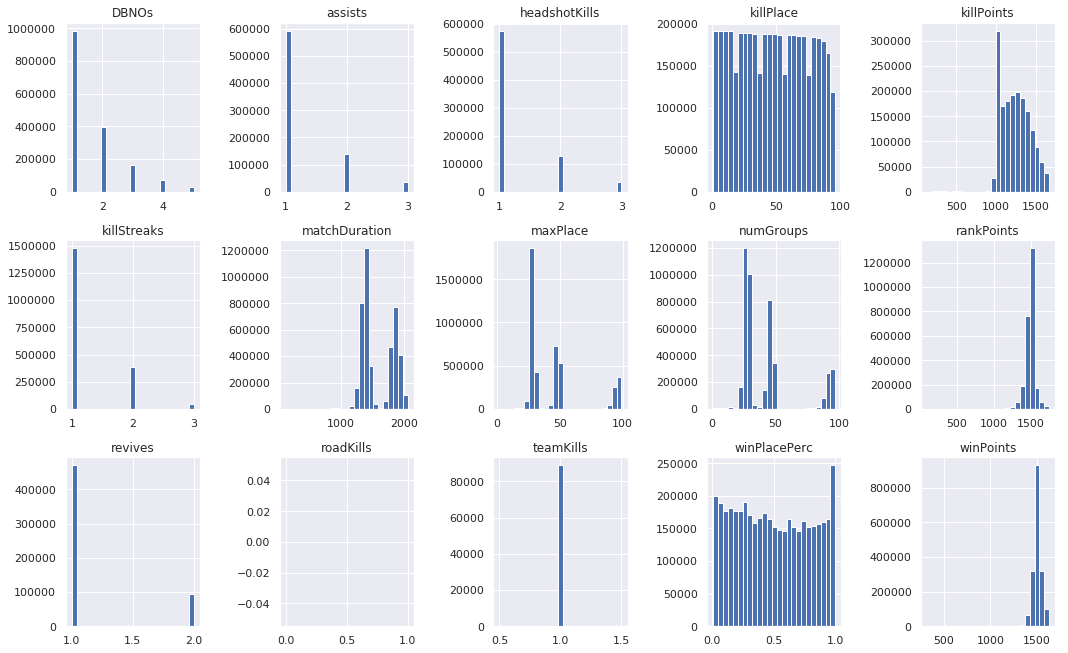

In [61]:
df = train.drop(columns=['Id','matchId','groupId','matchType']+features)
df[(df>0) & (df<=df.quantile(0.99))].hist(bins=25,layout=(5,5),figsize=(15,15));
plt.tight_layout()

### Feature correlations 

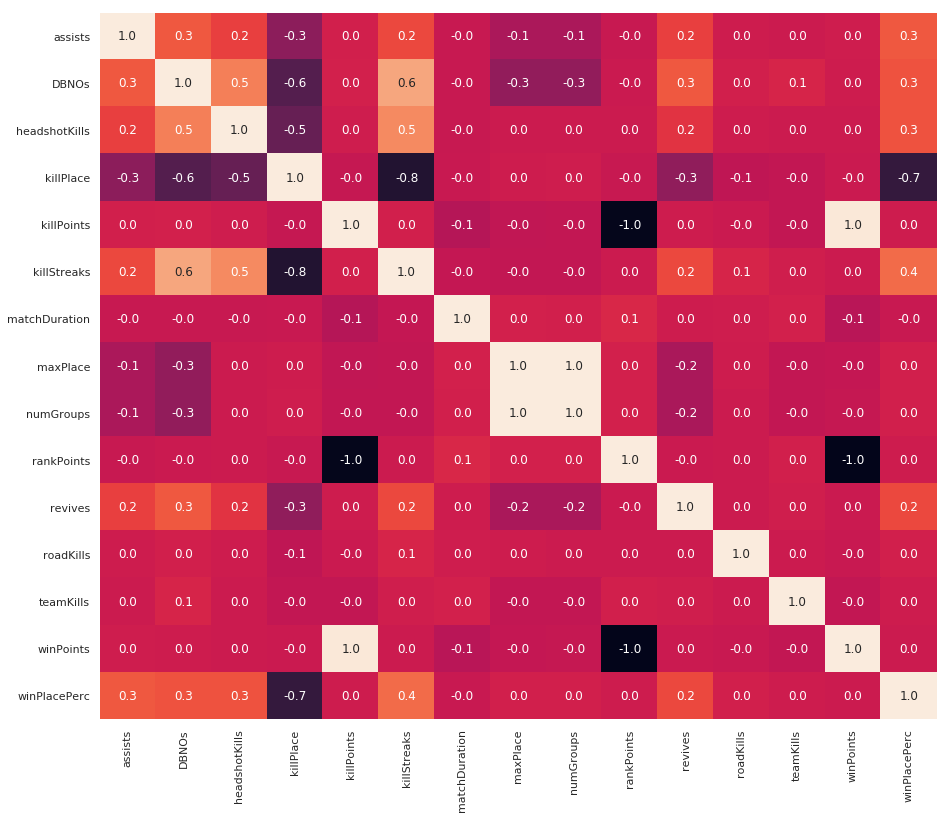

In [62]:
f,ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df.corr(), annot=True, fmt= '.1f',ax=ax,cbar=False)
plt.show()

Take features, which most correlate with target feature

walkDistance, killPlace, boosts, weaponsAcquired, damageDealt  most correlate with target feature


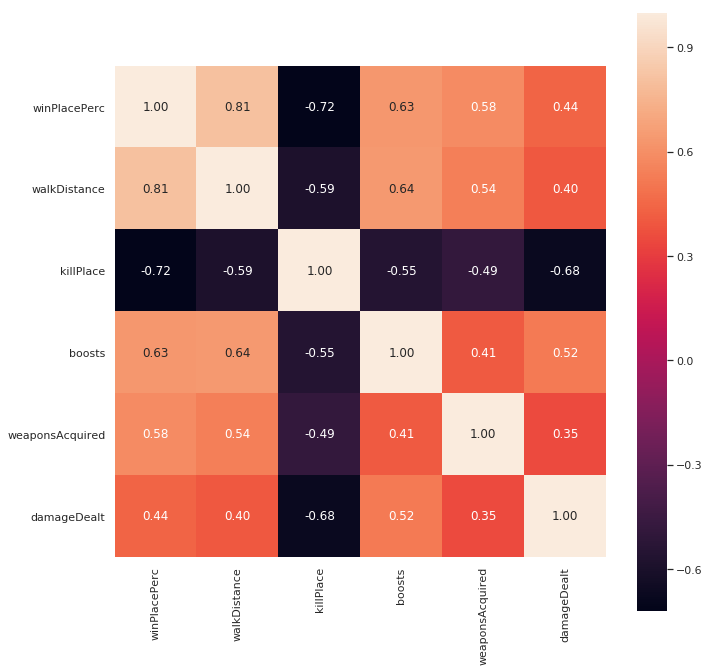

In [63]:
f,ax = plt.subplots(figsize=(11, 11))
cols = abs(train.corr()).nlargest(6, 'winPlacePerc')['winPlacePerc'].index
hm = sns.heatmap(np.corrcoef(train[cols].values.T), annot=True, square=True, fmt='.2f',  yticklabels=cols.values, xticklabels=cols.values)
print(", ".join(cols[1:]), " most correlate with target feature")
plt.show()

Let's make pairplots. We can clearly see correlation with winPlacePerc (but maybe only with weaponsAcquired it's difficult to see)

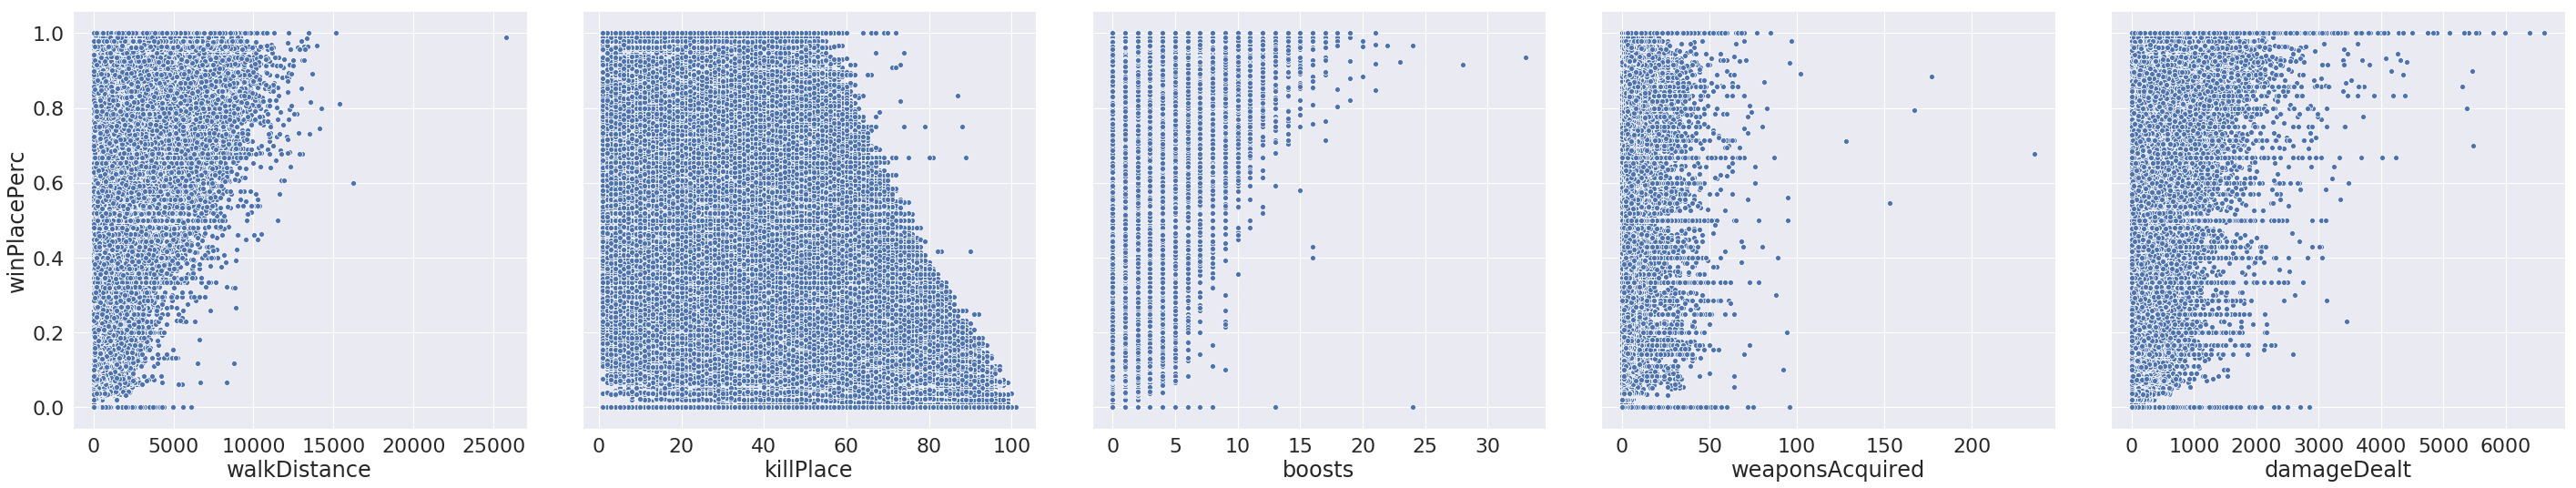

In [64]:
sns.set(font_scale=2)
sns.pairplot(train, y_vars=["winPlacePerc"], x_vars=cols[1:],height=8);
sns.set(font_scale=1)

### Match statistics

In [65]:
print("Number of match in train dataset:",train['matchId'].nunique())

Number of match in train dataset: 47964


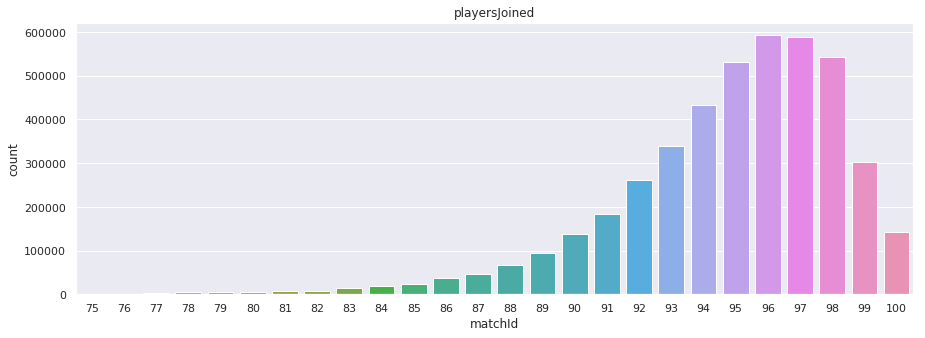

In [66]:
playersJoined = train.groupby('matchId')['matchId'].transform('count')
sns.countplot(playersJoined[playersJoined>=75])
plt.title('playersJoined');

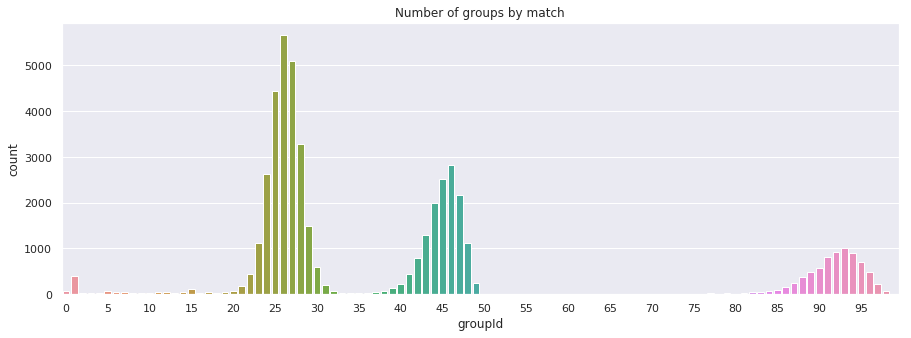

In [67]:
ngroupsByMatch = train.groupby('matchId')['groupId'].nunique()
ax = sns.countplot(ngroupsByMatch)
plt.title('Number of groups by match');
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5)) #Starts from 0 not from 1:(

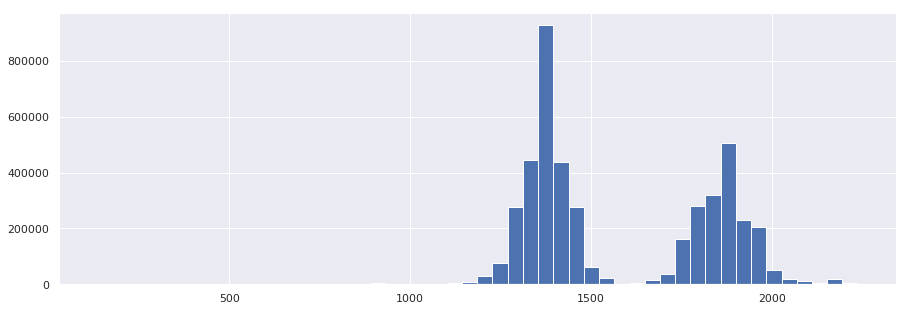

In [68]:
train.matchDuration.hist(bins=50);

We can see 3 peaks on second plot and 2 peaks in match duration plot. Presumably, it depends from match type.

**Some stats by matchType**

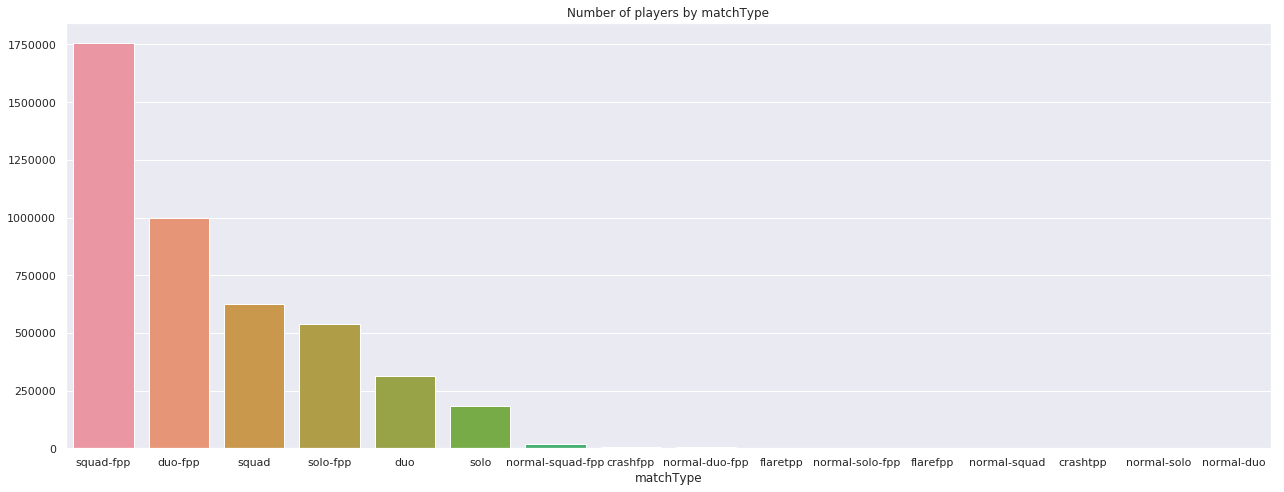

In [69]:
plt.rcParams['figure.figsize'] = 18,7;
types = train.groupby('matchType').size().sort_values(ascending=False)
sns.barplot(x=types.index,y=types.values);
plt.title("Number of players by matchType");
plt.tight_layout()

So, people usually play in squads or pairs. (or maybe just data collected in this way) <br/><br/>
At the end,  some numbers, which describe each type of game by number of players, groups, matches and etc.
<br/>  In this table np.size - number of players and  _num - number of matches. We can see that maxPlace and numGroups are almostly the same.

In [70]:
def _min(x):
    return x.value_counts().values.min()
def _max(x):
    return x.value_counts().values.max()
def _avg(x):
    return x.value_counts().values.mean()
def _med(x):
    return np.median(x.value_counts().values)
def _num(x):
    return x.nunique()
infostat = train.groupby('matchType').agg({
    "matchId": [np.size, _num, _min,_med,_max], #np.size - number of players, _num - number of matches
    "groupId": [_min,_med,_max],
    "matchDuration": [min,np.median, max], 
    "maxPlace": [min,np.median,max],
    "numGroups":[min,np.median,max]
    }).sort_values(by=('matchId','size'),ascending=False)  
display(infostat)

matchId                   ...  maxPlace numGroups            
                     size   _num _min  _med ...       max       min median  max
matchType                                   ...                                
squad-fpp         1756186  18576    5 96.00 ...        37         2     27   37
duo-fpp            996691  10620    7 95.00 ...        51         4     46   51
squad              626526   6658   18 95.00 ...        34         6     27   33
solo-fpp           536761   5678    8 96.00 ...       100         8     93  100
duo                313591   3356   38 95.00 ...        51        18     46   50
solo               181943   2297   11 95.00 ...       100         1     92   99
normal-squad-fpp    17174    358    6 56.00 ...        27         2     15   25
crashfpp             6287     73   20 92.00 ...        52        12     46   52
normal-duo-fpp       5489    158    7 26.00 ...        50         1     31   49
flaretpp             2505     29   57 89.00 ...        28        15     24   27
normal-solo-fpp      1682     96    2 14.00 ...        54         2     13   51
flarefpp              718      9   60 87.00 ...        29        16     25   29
normal-squad          516     16   13 29.00 ...        25         2      8   25
crashtpp              371      5   59 71.00 ...        46        29     33   44
normal-solo           326     23    6 11.00 ...        44         4     11   29
normal-duo            199     12    8 14.50 ...        20         4      8   20

[16 rows x 17 columns]

## 4. Insights and found dependencies

 &nbsp;&nbsp;&nbsp;&nbsp; We found, that walkDistance, killPlace, boosts, weaponsAcquired and damageDealt - is most correlated features. It easy to guess why.
<br/>     &nbsp;&nbsp;&nbsp;&nbsp;  If you are close to the top, more likely, that you walk greater distance, because you have to be in the circle (game zone). More likely, that you find a good weapon and/or kill somebody. If you kill somebody, your enemy can hurt you, so then it's better to use boost. Near each killed enemy, you can find his/her loot and ,probably, you acquire some his/her weapons.
<br/>
 &nbsp;&nbsp;&nbsp;&nbsp; Also we can see, that a lot of people play in squads or duos (play in groups). Players in one team have the same finish placement. Finish result depends from team work. So it's better to see general statistic by team, not by separate player.

*Game zones*
![game zones](https://github.com/4ku/PUBG-prediction/raw/master/pictures/Circle%20zones.png)

## 5. Metrics selection

&nbsp;&nbsp;&nbsp;This task is regression problem. For regression problem we know only `mean absolute error` (MAE), `mean squared error` (MSE; also root MSE exists  ) and `mean squared log error` (MSLE; root MSLE exists too). <br/>
&nbsp;&nbsp;&nbsp;Our target have uniform distribution with range from 0 to 1. But MSLE more appropriate for not uniform distribution and MSE usually use, when large errors are particularly undesirable. We are not in this situations, so **MAE** will be convenient for us.

![](https://github.com/4ku/PUBG-prediction/raw/master/pictures/Love%20MAE.png)

## 6. Model selection

I decided to use **LightGBM**. With LightGBM convenient to work with large datasets (our case). LightGBM more faster than, for example, XGBoost and give good score at the same time. There are lots of parameters to tune (main problem) and it supports solving regression problems.

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/importLGB.jpg" width="500" height="190"> 


In [71]:
import lightgbm as lgb

## 7. Data preprocessing

As I already mentioned, we are going to group player statistics to teams (by groupId).

In [72]:
# Function, which reduce memory usage. 
# This function I took from ready kernel (https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

 &nbsp;&nbsp;&nbsp;&nbsp;In next steps we will create new features. That's why this step will repeat again. So, at this stage, make simple data preparation. We just group all by team and than make a ranking in each match.
<br/>
 >&nbsp; Ranking - scaling, where the lowest value in initial table replace to value about zero (depends from distribution; no lower than 0) and maximum value replace to value about 1 (no higher than 1).

In [73]:
def initial_preparing(df, Debug):
    if Debug:
        df = df[df['matchId'].isin(df['matchId'].unique()[:2000])]
    # Drop next columns. *Points features don't correlate with target feature, need
    # more EDA to understand how they work.
    df.drop(columns=['killPoints','rankPoints','winPoints','matchType','maxPlace','Id'],inplace=True)
    X = df.groupby(['matchId','groupId']).agg(np.mean)
    X = reduce_mem_usage(X)
    y = X['winPlacePerc']     
    X.drop(columns=['winPlacePerc'],inplace=True)
    X_ranked = X.groupby('matchId').rank(pct=True)
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, how='left', on=['matchId', 'groupId'] )
    X.drop(['matchId','groupId'],axis=1, inplace=True)
    X = reduce_mem_usage(X)
    return X, y

In [74]:
X_train, y = initial_preparing(train.copy(),False)

Memory usage of dataframe is 356.01 MB
Memory usage after optimization is: 112.47 MB
Decreased by 68.4%
Memory usage of dataframe is 324.72 MB
Memory usage after optimization is: 92.78 MB
Decreased by 71.4%


Split our train dataset to part, which we are going to train (X_train; same name), and to part with which we will check an error.

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y, test_size=0.2, random_state=666)

## 8-9. Cross-validation and adjustment of model hyperparameters. Creation of new features and description of this process

In [76]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

I choose 5 folds in cross-validation. We have a big dataset, so it's not necessary to set more folds, 80% for train part is enough to train model.  Moreover, If I choose higher number, than it will take a lot of time to compute. 

In [77]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train.reset_index(drop=True))
res = lgb.cv({'metric': 'mae'},lgtrain, nfold=5,stratified=False,seed=666)
print("Mean score:",res['l1-mean'][-1])
gc.collect()

Mean score: 0.04913347313706198
CPU times: user 3min 16s, sys: 888 ms, total: 3min 17s
Wall time: 51.3 s


So, our score is 0.0644. It's not bad. It means that our model error is +-6.42 placements (if there are 100 players on server)

Lets add new features and make ranking again.

When we aggregate dataset by groupId, we create "new" features, i.e. we can aggregate by different ways. <br/>
For example, 'boosts':sum - total number of using boosts in one team.

In [78]:
team_features = {
        'assists': [sum, np.mean, np.size], #np.size - size of team
        'boosts' : [sum, np.var, np.mean], 
        'heals': [sum, np.var, np.mean],
        'damageDealt': [np.var,min,max,np.mean],
        'DBNOs': [np.var,max,np.mean],
        'headshotKills': [max,np.mean],
        'killPlaceScall':[sum, min,max, np.var, np.mean],
        'kills': [ sum, max, np.var,np.mean],
        'killStreaks': [max,np.var,np.mean],
        'longestKill': [max, np.mean, np.var],
        'revives': sum,
        'rideDistance': [sum, np.mean,np.var],
        'swimDistance': [np.var],
        'teamKills': sum,
        'vehicleDestroys': sum,
        'walkDistance': [np.var,np.mean],
        'weaponsAcquired': [np.mean],
        'damageRate': [np.var,min,max,np.mean],
        'headshotRate': [np.var,max,np.mean],
        'killStreakRate': [np.var,np.max, np.mean],
        'healthItems': [np.var, np.mean],
        'healsOnKill': [ np.var, np.mean],
        'sniper': [ np.var, np.mean],
        'totalDistance': [sum, np.var, np.mean],
        'totalDistancePen': [ sum ,np.var, np.mean],
        'killsPerRoadDist': [np.mean],
        'killsPerWalkDist': [np.mean],
        'killsPerDist': [np.mean],
        'distance_over_weapons': [np.mean],
        'walkDistance_over_heals': [np.mean],
        'skill': [np.var,np.mean]
}

**New features** <br/>
<br/> &nbsp;&nbsp; &nbsp; `killPlaceScall` - scaled `killPlace` feature. Just divide `killPlace` on number of players in a match.
<br/> &nbsp;&nbsp; &nbsp; `damageRate` - ratio `kills` and `damageDealt/100`. If `damageRate`>1, player killed enemies, who was already damaged. So it was more easies to kill them.
If this feature <1, it means that player deal more damage than he/she kill - player had  a difficult battle or just a little damage  some players, whose he/she don't kill. 
<br/>  &nbsp;&nbsp; &nbsp;`headshotRate` - percentage of headshot kills. Shows skill of player
<br/>  &nbsp;&nbsp; &nbsp;`killStreakRate` - percentage of killStreak from all kills. Also shows player skill
<br/>  &nbsp;&nbsp; &nbsp;`healthItems` - total number of health items (heals+boosts). 
<br/>  &nbsp;&nbsp; &nbsp;`healsOnKill` - equal to `healsItems`/`kills`. It shows how good player was in a battle. If player don't use heals after kill, it probably means, that he/she don't take damage.
<br/>  &nbsp;&nbsp; &nbsp;`sniper` - equal to `longestKill`/100*`weaponsAcquired`. It shows player sniper skill. Usually snipers have a good weapon. To find this weapon, player more likeky need acquired a lot other weapons. Yea, it's strange feature.
<br/>  &nbsp;&nbsp; &nbsp;`totalDistance` -  `rideDistance` + `walkDistance` + `swimDistance`.  Big distance means that player survived for long period of time, so he/she will take a good final place.
<br/>  &nbsp;&nbsp; &nbsp;`totalDistancePen` - penalized `totalDistance`. It's needed to predict time of player game . So vehicle speed is approximately 5 times higher than player walk speed and swim speed is approximately 10 times lower than player walk speed.
<br/>  &nbsp;&nbsp; &nbsp;`killsPerRoadDist` - kills per distance. This feature can show your skill too. It's difficult to kill enemy using vehicle. 
<br/>  &nbsp;&nbsp; &nbsp;`killsPerWalkDist` - represent player style. It shows you are camper or always in moving.
<br/>  &nbsp;&nbsp; &nbsp;`killsPerDist` - just combination of `killsPerRoadDist` and `killsPerWalkDist`
<br/>  &nbsp;&nbsp; &nbsp;`distance_over_weapons` - low values can represent that player try to find loot by yourself and/or he/she don't satisfied his/her equipment, high values can mean that player just take loot from killed people and/or he/she has good equipment. Of course, it's not always true.
<br/>  &nbsp;&nbsp; &nbsp;`walkDistance_over_heals` - may represent player battles per distance.
<br/>  &nbsp;&nbsp; &nbsp;`skill` - equal to `headshotKills` + `roadKills` + `teamKills`. Just one of the indicator of player skill.

In [79]:
def featuring(df, isTrain, Debug):
    y=None
    if Debug:
        df = df[df['matchId'].isin(df['matchId'].unique()[:2000])]
 
    #Creating new features
    #_________________________________________________________________________________________

    nplayers = df.groupby('matchId')['matchId'].transform('count')
    df['killPlaceScall'] = df['killPlace'] / nplayers
    df['damageRate'] = df['kills']/(0.01*df['damageDealt'])
    df['headshotRate'] = df['headshotKills']/df['kills']
    df['killStreakRate'] = df['killStreaks']/df['kills']
    df['healthItems'] = df['heals'] + df['boosts']
    df['healsOnKill'] = df['healthItems']/df['kills']
    df['sniper'] = df['longestKill']/100*df['weaponsAcquired']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['totalDistancePen'] = df['rideDistance']/5 + df["walkDistance"] + df["swimDistance"]*10
    df['killsPerRoadDist'] = df['roadKills'] / (df['rideDistance']+1)
    df['killsPerWalkDist'] = (df['kills']-df['roadKills']) / (df['walkDistance']+1)
    df['killsPerDist'] = df['kills']/(df['totalDistance']+1)
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance']/100/df['heals']
    df["skill"] = df["headshotKills"] + df["roadKills"] - df['teamKills'] 
    df.fillna(0,inplace=True)
    df.replace(np.inf, 0, inplace=True)
    #_________________________________________________________________________________________
    
    ids = df[['matchId','groupId','Id']]
    df.drop(columns=['killPlace','killPoints','rankPoints','winPoints','matchType','maxPlace','Id'],inplace=True)
    
    tfeatures = team_features.copy()
    if isTrain:
        tfeatures['winPlacePerc'] = max
    X = df.groupby(['matchId','groupId']).agg(tfeatures)
    X.fillna(0,inplace=True)
    X.replace(np.inf, 1000000, inplace=True)
    X = reduce_mem_usage(X)    
    if isTrain:
        y = X[('winPlacePerc','max')]     
        X.drop(columns=[('winPlacePerc','max')],inplace=True)
             
   
    #Group dataset by matches. To each match apply ranking 
    X_ranked = X.groupby('matchId').rank(pct=True)    
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, suffixes=["", "_rank"], how='left', on=['matchId', 'groupId'] )

    ids_after = X[['matchId','groupId']]
    ids_after.columns = ['matchId','groupId']
    
    X = X.drop(['matchId','groupId'],axis=1)
    X.columns = [a+"_"+b for a,b in X.columns]
    X = reduce_mem_usage(X)
    
    return X, y, ids,ids_after

In [80]:
%%time
X_train, y, _,_ = featuring(train,True,False)
X_test, _,ids_init,ids_after = featuring(test,False,False)

Memory usage of dataframe is 1160.08 MB
Memory usage after optimization is: 340.55 MB
Decreased by 70.6%
Memory usage of dataframe is 1128.79 MB
Memory usage after optimization is: 293.79 MB
Decreased by 74.0%
Memory usage of dataframe is 498.81 MB
Memory usage after optimization is: 139.61 MB
Decreased by 72.0%
Memory usage of dataframe is 493.59 MB
Memory usage after optimization is: 128.47 MB
Decreased by 74.0%
CPU times: user 3min 48s, sys: 1min 23s, total: 5min 11s
Wall time: 5min 7s


Split our train dataset again

In [81]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y, test_size=0.2, random_state=666)

In [82]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train.reset_index(drop=True))
res = lgb.cv({'metric': 'mae'},lgtrain, nfold=5,stratified=False,seed=666)
print("Mean score:",res['l1-mean'][-1])

Mean score: 0.03391844872889481
CPU times: user 8min 23s, sys: 1.9 s, total: 8min 25s
Wall time: 2min 10s


We get a significant improvement (almost in 2 times). So new features really help to understand the data.
<br/>
<br/> 
Now let's tune LightGBM. To do this, we are going to use GridSearchCV, which helps find the best parameters.

In [83]:
gridParams = {
    'num_leaves': [30,50,100], 'max_depth': [-1,8,15], 
    'min_data_in_leaf': [100,300,500], 'max_bin': [250,500], 
    'lambda_l1': [0.01], 'num_iterations': [5], 
    'nthread': [4], 'seed': [666],
    'learning_rate': [0.05], 'metric': ['mae'],
    "bagging_fraction" : [0.7], "bagging_seed" : [0], "colsample_bytree" : [0.7]
    }
model = lgb.LGBMRegressor()
grid = GridSearchCV(model, gridParams,
                    verbose=1,
                    cv=5)

We are going to tune `num_leaves`,  `max_depth`,  `min_data_in_leaf` and `max_bin`, because it's main parameters in LightGBM. 
<br/> &nbsp;&nbsp; &nbsp;`num_leaves` -  max number of leaves in one tree. It's the main parameter to control the complexity of the tree model.
<br/> &nbsp;&nbsp; &nbsp;`max_depth` - limit the max depth for tree model. This is used to deal with over-fitting. -1 means no limit
<br/> &nbsp;&nbsp; &nbsp;`min_data_in_leaf` - minimal number of data in one leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and <br/> &nbsp;&nbsp; &nbsp;`num_leaves`.
<br/> &nbsp;&nbsp; &nbsp;`max_bin` - max number of bins that feature values will be bucketed in. Small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)

There we take only 500 000 teams out of 1 500 000. As we will see further (on learning curve), it's enough to find best params.

In [84]:
%%time
grid.fit(X_train.iloc[:500000,:], y_train.iloc[:500000])

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 17.9min finished


CPU times: user 44min 24s, sys: 3min 36s, total: 48min
Wall time: 17min 56s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [30, 50, 100], 'max_depth': [-1, 8, 15], 'min_data_in_leaf': [100, 300, 500], 'max_bin': [250, 500], 'lambda_l1': [0.01], 'num_iterations': [5], 'nthread': [4], 'seed': [666], 'learning_rate': [0.05], 'metric': ['mae'], 'bagging_fraction': [0.7], 'bagging_seed': [0], 'colsample_bytree': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [85]:
print("Best params:", grid.best_params_)
print("\nBest score:", grid.best_score_)
params = grid.best_params_

Best params: {'bagging_fraction': 0.7, 'bagging_seed': 0, 'colsample_bytree': 0.7, 'lambda_l1': 0.01, 'learning_rate': 0.05, 'max_bin': 500, 'max_depth': -1, 'metric': 'mae', 'min_data_in_leaf': 100, 'nthread': 4, 'num_iterations': 5, 'num_leaves': 100, 'seed': 666}

Best score: 0.3743635377044939


Best score is worse than after cross-validation, because there was taken 5 iterations,  and in cross-validation - 100 iterations. But it's will be OK, when we set higher number of iterations with parameters, which we find now.

## 10. Plotting training and validation curves

Now let's plot learning curve with different sizes of trainsets.

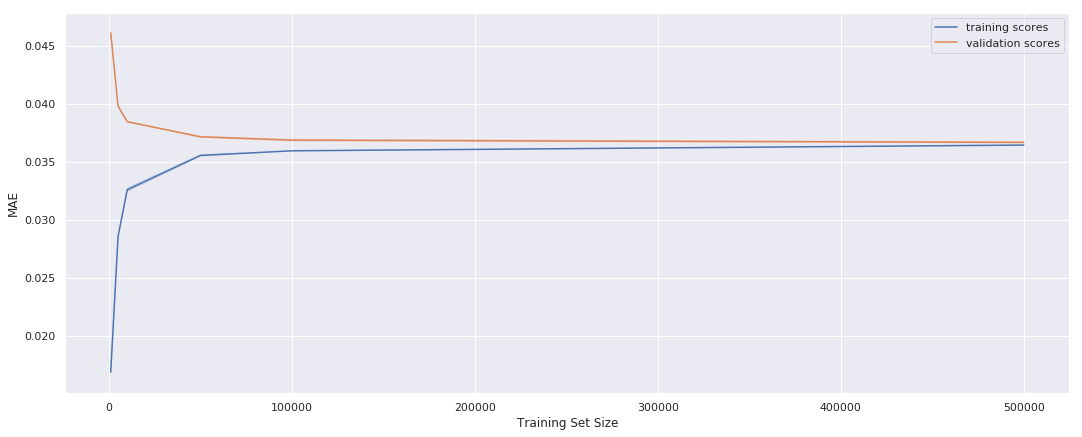

In [86]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
model = lgb.LGBMRegressor(learning_rate=0.05,nthread=4)

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_learning_curve():
    train_sizes = [1000,5000,10000,50000,100000,500000]
    N_train, val_train, val_test = learning_curve(model,
    X_train, y_train, train_sizes=train_sizes, cv=5,
    scoring='neg_mean_absolute_error')
    plot_with_err(N_train, abs(val_train), label='training scores')
    plot_with_err(N_train, abs(val_test), label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('MAE')
    plt.legend()

plot_learning_curve()

As we can see, at small sizes of trainset, we have a big difference in train and validation scores. The reason is overfitting of train set and lack of data.
<br/> But with increasing size, this curves converge. With 500 000 train size this difference is very small. That's why I took 500 000 instead of all trainset in GridSearchCV.

Now look how score depends from number of iterations.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.3min finished


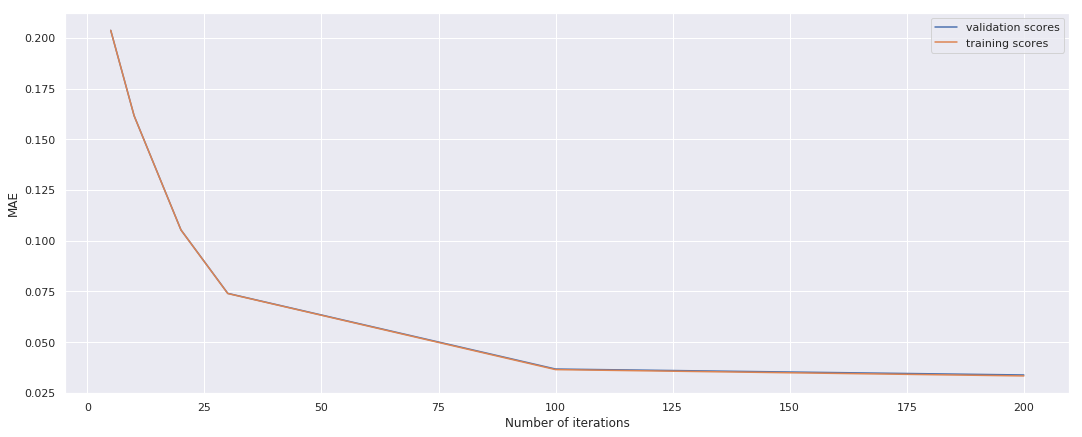

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 52.9min finished


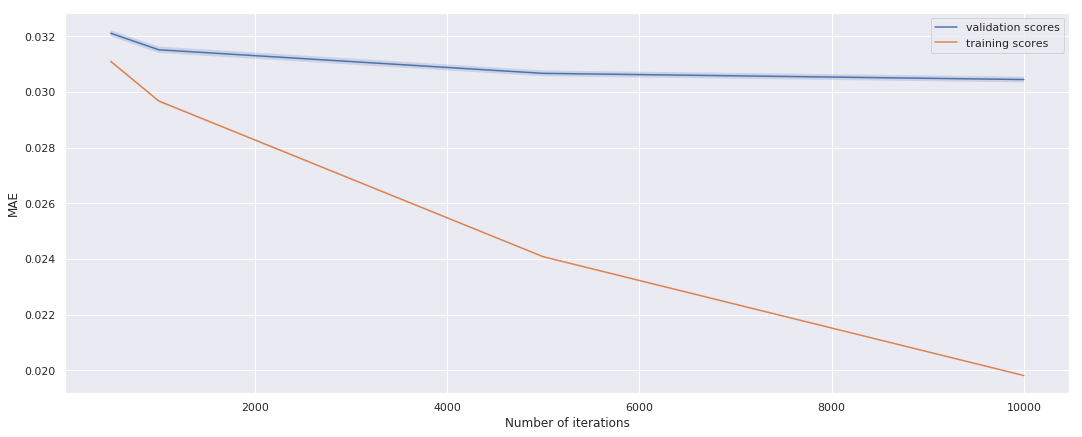

In [87]:
def iter_vs_score(num_iterations):
    val_train, val_test = validation_curve(model, X_train[:500000], y_train[:500000],
        'num_iterations', num_iterations, cv=4,scoring='neg_mean_absolute_error', verbose=1)
    plot_with_err(num_iterations, abs(val_test), label='validation scores')
    plot_with_err(num_iterations, abs(val_train), label='training scores')
    plt.xlabel('Number of iterations'); plt.ylabel('MAE')
    plt.legend();
    plt.show();

num_iterations_small = [5,10,20,30,100,200]
iter_vs_score(num_iterations_small)
num_iterations_big = [500,1000,5000,10000]
iter_vs_score(num_iterations_big)

For small number of iterations, error fall down quickly. For large iterations error goes down, but slowly. Also we  can notice, that validation and training scores are approximetly the same for small number of iterations. For big number of iterations we can see, that score for training set continue to go down,  for validation set it goes down too, but much more slower. So curves diverge, but there are no overfitting, because validation score continue go down.

## 11. Prediction for test and hold-out samples

Let's train LightGBM model with params, which we had found with GridSearchCV.  In the same time we will compute error on hold-out set every 1000 iterations. Total number of iterations is 5000, it's should me enough. If we take higher number of iterations, we won't get significant improvement or can even get overfitting.

In [88]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_holdout, label=y_holdout)

params['num_iterations'] = 5000
model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], early_stopping_rounds=200, verbose_eval=1000)

Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 0.0288691	valid_1's l1: 0.0301816
[2000]	training's l1: 0.0273366	valid_1's l1: 0.0297064
[3000]	training's l1: 0.02616	valid_1's l1: 0.0294649
[4000]	training's l1: 0.0251339	valid_1's l1: 0.0292754
[5000]	training's l1: 0.0242089	valid_1's l1: 0.0291146
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0242089	valid_1's l1: 0.0291146
CPU times: user 1h 9min 56s, sys: 8.08 s, total: 1h 10min 4s
Wall time: 17min 41s


We get 0.0291 for holdout set and 0.0242 for train set. It's obviously better than our previous scores. Now make a prediction for test set and put results to file `submission.csv`

In [ ]:
pred_test = model.predict(X_test, num_iteration=model.best_iteration)

ids_after['winPlacePerc'] = pred_test
predict = ids_init.merge(ids_after, how='left', on=['groupId',"matchId"])['winPlacePerc']
df_sub = pd.read_csv("../input/sample_submission_V2.csv")
df_test = pd.read_csv("../input/test_V2.csv")
df_sub['winPlacePerc'] = predict
df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)

In public leaderboard I get 0.0272. Not bad)

## 12. Conclusions

&nbsp;&nbsp; &nbsp;We get a good score. But, of course, it can be better. There are lot of ways to do this. For example, I deleted `killPoints`,`rankPoints`and `winPoints` features. They may be helpfull, if correctly iterpret them. Also there are lots of cheaters in a game. So cheaters should be processed. I just slightly tuned LightGBM, we can find better parameters or even try other model.
<br/>&nbsp;&nbsp; &nbsp;In the begining, I mentioned about [PUBG Developer API](https://developer.pubg.com/). We can get more features with it, so can make more complex model. It will be cool to create app, which give you tips in real time during the match. This solution can bring closer this idea or just help PUBG community by other way.


Thank you for reading and sorry for my English)

<img src="https://github.com/4ku/PUBG-prediction/raw/master/pictures/Winner-winner.jpg" width="600" height="600"> 

Efremov Ivan